In [52]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Dstaset creation

In [53]:
emotions_tras = {1:1, 2:4, 3:5, 4:0, 5:3, 6:2, 7:6}
emotions = {0:'angry', 1:'calm', 2:'disgust', 3:'fear', 4:'happy', 5:'sad', 6:'surprise'}

dataset_path = "data_frames_face_BW/"
models_path = "Models/Video_stream/"

height_orig = 224
width_orig = 224
height_targ = 112
width_targ = 112

num_classes = len(emotions)

test_actors = ['21', '22', '23', '24']

In [54]:
filenames_test = [] # test

for dirpath, dirnames, fn in os.walk(dataset_path):
    dirnames.sort()
    # print(dirpath)
    if fn != []:
        class_temp = int(fn[0].split('-')[2]) - 1
        if class_temp != 0:                                                     # exclude 'neutral' label
            if any(act in dirpath for act in test_actors):                      # select only train actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)                   # emotion trasposition
                filenames_test.append(list(zip(path, label)))
num_videos = len(filenames_test)
num_videos


448

In [55]:
def sampling(list, num_frames_desired):
    tot = []
    for elem in list:
        sampled_list = random.sample(elem, num_frames_desired)
        # tot.append(sampled_list)
        tot += sampled_list
    return(tot)

def parse_image(filename):
    
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
    image = tf.image.resize(image, [height_targ, width_targ])
    print('shape frames:', image.shape)
    return image

def configure_for_performance(ds, batch_size):
    # ds = ds.shuffle(buffer_size=1000) # serve?
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def load_dataset(filenames, frames_per_vid):
    print("frames per video:", frames_per_vid) 
    batch_size = frames_per_vid

    filenames_sampled = sampling(filenames, frames_per_vid)
    # random.shuffle(filenames_sampled)
    # print(len(filenames_sampled))

    zipped = [list(t) for t in zip(*filenames_sampled)]

    names = zipped[0]
    labels = zipped[1]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))
    ds = configure_for_performance(ds, batch_size)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [56]:

frames_per_vid = min([len(elem) for elem in filenames_test])     # number of frames per clip in order to have balanced classes
test_ds, step_per_epoch_test = load_dataset(filenames_test, frames_per_vid)

frames per video: 24
shape frames: (112, 112, 1)
frames number: 10752 
batch size: 24 
batch number: 448


(112, 112, 1)
calm


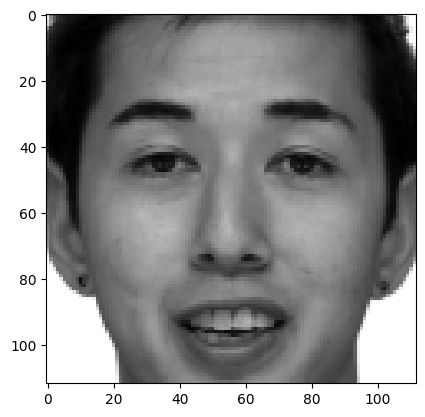

In [57]:
b = test_ds.unbatch().take(1)

for elem in b:
    print(elem[0].shape)
    print(emotions[int(elem[1])])
plt.imshow(elem[0], cmap='gray')

### Load the Best Model

In [58]:
models_list = os.listdir(models_path)

acc = [float(model.split('[')[1].split(']')[0]) for model in models_list]
idx = acc.index(max(acc))                                                       # index of best model

reconstructed_model = keras.models.load_model(models_path + models_list[idx])
reconstructed_model.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      832       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 112, 112, 32)     128       
 tion)                                                           
                                                                 
 activation (Activation)     (None, 112, 112, 32)      0         
                                                                 
 maxpool2d_0 (MaxPooling2D)  (None, 56, 56, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        51264     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 56, 56, 64)       256       
 tion)                                                        

## Prediction

#### Evaluate Single Frame

In [59]:
loss_single_frame, acc_single_frame = reconstructed_model.evaluate(test_ds, steps=step_per_epoch_test)
print('accuratezza single frame:', round(acc_single_frame, 4))

448/448 [==============================] - 81s 180ms/step - loss: 1.5772 - sparse_categorical_accuracy: 0.5363
accuratezza single frame: 0.5363


In [60]:
predic = reconstructed_model.predict(test_ds, steps=step_per_epoch_test).argmax(axis=1)
ground = [elem[0][1]  for elem in filenames_test]
ground = np.repeat(ground, frames_per_vid)

448/448 [==============================] - 82s 182ms/step


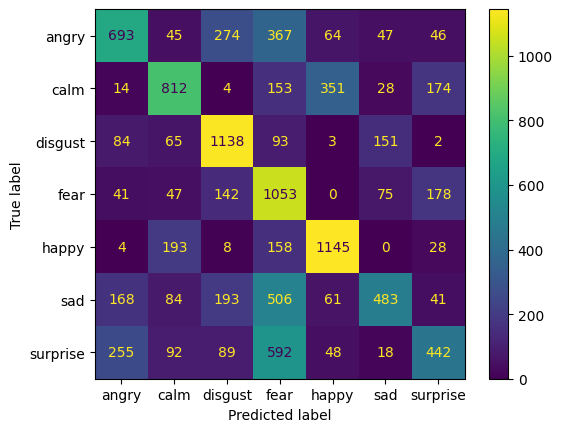

In [61]:
cm = confusion_matrix(ground, predic)
disp = ConfusionMatrixDisplay(cm, display_labels=list(emotions.values()))
disp.plot()
# plt.savefig('Plots/VideoCM_Frame.png')

In [62]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

stats = pd.DataFrame({'Recall': recall, 'Precision': precision}, index=emotions.values())
round(stats, 2)

,Recall,Precision
angry,0.45,0.55
calm,0.53,0.61
disgust,0.74,0.62
fear,0.69,0.36
happy,0.75,0.68
sad,0.31,0.60
surprise,0.29,0.49


#### Evaluate Full Video

In [63]:
pred = reconstructed_model.predict(test_ds, steps=step_per_epoch_test)


448/448 [==============================] - 83s 185ms/step


In [64]:
example_id = 0
example = np.array_split(pred, num_videos)[example_id]

print('ground truth:\t', filenames_test[example_id][0][1])
print('predicted:\t', np.mean(example, axis=0).argmax())

ground truth:	 1
predicted:	 1


In [65]:
pred_list = np.array_split(pred, num_videos)

ground = []
predic = []

i = 0
for count, video in enumerate(pred_list):
    predic.append(np.mean(video, axis=0).argmax())
    # predic.append(np.average(video, axis=0, weights=np.max(video, axis=1)).argmax()) # weighted mean on highest prediction value
    ground.append(filenames_test[count][0][1])
    
    if predic[count] == ground[count]:
        i += 1

print('accuracy full video:\t', round(i/len(pred_list), 4))
print('Num videos:\t\t', count+1)

    

accuracy full video:	 0.6295
Num videos:		 448


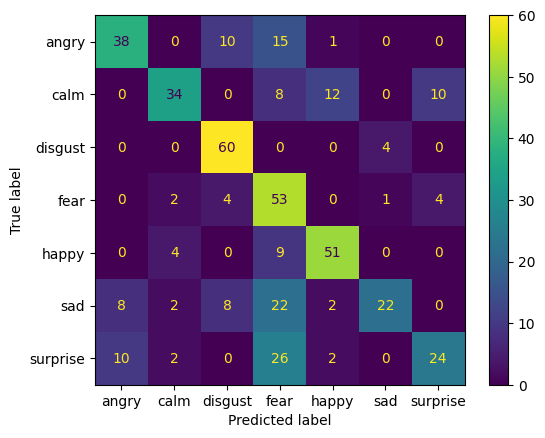

In [66]:
cm = confusion_matrix(ground, predic)
disp = ConfusionMatrixDisplay(cm, display_labels=list(emotions.values()))
disp.plot()
# plt.savefig('Plots/VideoCM_FullVideo.png')

In [67]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

stats = pd.DataFrame({'Recall': recall, 'Precision': precision}, index=emotions.values())
round(stats, 2)

,Recall,Precision
angry,0.59,0.68
calm,0.53,0.77
disgust,0.94,0.73
fear,0.83,0.40
happy,0.80,0.75
sad,0.34,0.81
surprise,0.38,0.63
